In [1]:
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

# your path to data
train_path = r'/DATA/vvikhrov/train.lmdb'
test_path = r'/DATA/vvikhrov/test.lmdb'
gt_path = '/DATA/vvikhrov/gt.txt'

# My solution using resnet18 & centerloss

resnet18 with first layer changed in order to match greyscale image. I've tried cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB), but this made things only worse. I've also tried some resize methods using torchvision transforms, but without any improvements. So I just used the baseline, but only changed image size to 64x64.

CenterLoss source: https://github.com/KaiyangZhou/pytorch-center-loss



In [2]:
import cv2
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision import models
from matplotlib import pyplot as plt

### Data tools

In [3]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [7]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (64, 64)) - 127.5) / 255., label

In [8]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

### Model & training

In [9]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [10]:
'''
0 -> 2
1 -> 0
2 -> 1
3 -> 3
'''

gpu_number = 1
device = torch.device(device=f'cuda:{gpu_number}')
device

device(type='cuda', index=1)

In [11]:
n_classes = train_helper.vocabulary.num_classes()

In [12]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes=n_classes, feat_dim=512):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim

        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(device))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [13]:
class resnet_center_loss(nn.Module):
    def __init__(self, n_classes):
        super(resnet_center_loss, self).__init__()
        self.net = models.resnet18()
        self.net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.head = nn.Linear(n_features, n_classes)
        
    def forward(self, imgs):
        features = self.net(imgs)
        output = self.head(features)
        return features, output

In [15]:
model = resnet_center_loss(n_classes).to(device)

In [16]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
center_loss = CenterLoss()
center_loss_optim = torch.optim.SGD(center_loss.parameters(), lr=0.5)

In [19]:
def run_centerloss_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            _, logits = model(X.unsqueeze(1).to(torch.float32).to(device))
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_centerloss_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn,
                          center_loss, center_loss_optim, alpha=0.5):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        features, logits = model(X.unsqueeze(1).to(torch.float32).to(device))
        
        loss = loss_fn(logits, y.to(torch.long).to(device))+ alpha * center_loss(features, y.to(device))
        
        optim.zero_grad()
        center_loss_optim.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optim.step()
        center_loss_optim.step()

Epoch 19:
accuracy: 0.9523463060552987


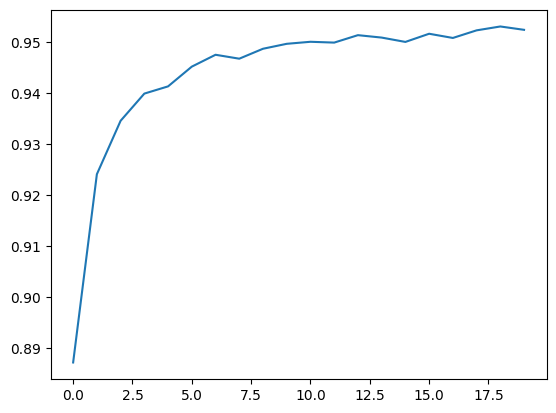

In [20]:
accuracies = []
for epoch in range(20):
    print(f'Epoch {epoch}:')
    train_centerloss_epoch(train_loader, val_loader, model, optim, loss_fn, center_loss, center_loss_optim)
    accuracy = run_centerloss_validation(val_loader, model)
    
    clear_output()
    print(f'Epoch {epoch}:')
    print(f'accuracy: {accuracy}')
    accuracies.append(accuracy)
    plt.plot(accuracies)
    plt.show()
    torch.save(model.state_dict(), f'resnet_centerloss{epoch}.pth')

Epoch 19:
accuracy: 0.8909959370719305


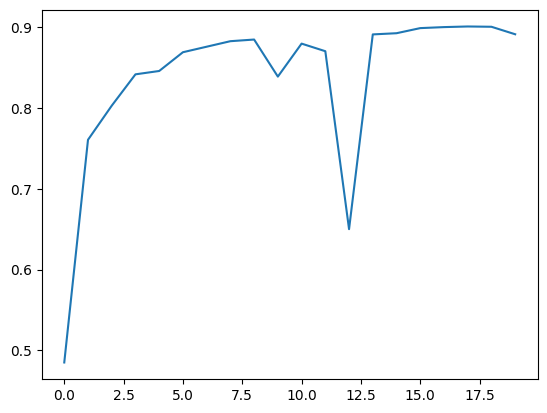

In [73]:
'''
archive: same net, 32x32 image
'''

accuracies = []
for epoch in range(20):
    print(f'Epoch {epoch}:')
    train_centerloss_epoch(train_loader, val_loader, model, optim, loss_fn, center_loss, center_loss_optim)
    accuracy = run_centerloss_validation(val_loader, model)
    
    clear_output()
    print(f'Epoch {epoch}:')
    print(f'accuracy: {accuracy}')
    accuracies.append(accuracy)
    plt.plot(accuracies)
    plt.show()
    torch.save(model.state_dict(), f'resnet_centerloss{epoch}.pth')

### Evaluation

In [21]:
torch.save(model.state_dict(), '64x64resnet_centerloss_final.pth')

In [100]:
model.load_state_dict(torch.load('resnet_centerloss18.pth'))

<All keys matched successfully>

In [22]:
# test_path = r'/home/egiby/data/Temp/HWDB/test.lmdb'
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [23]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [24]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        _, logits = model(X.unsqueeze(1).to(torch.float32).to(device))
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:40<00:00,  9.43it/s]


In [25]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [26]:
from pathlib import Path

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path) as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls
    
    n_good = 0
    n_all = len(gt)
    with open(pred_path) as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1
    
    return n_good / n_all


def _run_evaluation():
    base = Path().absolute().parent.parent
    pred_path = './pred.txt'
    score = evaluate(gt_path, pred_path)
    print('Accuracy = {:1.4f}'.format(score))

In [27]:
_run_evaluation()

Accuracy = 0.9283
